In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

## Data Loader

In [10]:
df_ny = pd.read_csv('../data/processed/ny.csv')
df_aus = pd.read_csv('../data/processed/austin.csv')

# Add the city name as a new column in each DataFrame
df_ny['city'] = 'New York'
df_aus['city'] = 'Austin'

# Append the DataFrames
df = pd.concat([df_ny, df_aus], ignore_index=True)

# Display the combined DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26200 entries, 0 to 26199
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          26200 non-null  object 
 1   grid          26200 non-null  float64
 2   bathroom      26200 non-null  float64
 3   bedroom       26200 non-null  float64
 4   car           26200 non-null  float64
 5   diningroom    26200 non-null  float64
 6   livingroom    26200 non-null  float64
 7   office        26200 non-null  float64
 8   utilityroom   26200 non-null  float64
 9   waterheater   26200 non-null  float64
 10  aircomp       26200 non-null  float64
 11  kitchenArea   26200 non-null  float64
 12  washer_dryer  26200 non-null  float64
 13  other         26200 non-null  float64
 14  date.1        26200 non-null  object 
 15  day           26200 non-null  object 
 16  month         26200 non-null  object 
 17  day_name      26200 non-null  object 
 18  hour          26200 non-nu

# Outlier Detection - Isolation Forest

In [11]:
# Function to detect outliers for multiple columns using Isolation Forest
def detect_outliers(df, columns, contamination=0.05, random_state=42):
    for column in columns:
        # Drop missing values and filter out rows where the appliance usage is 0
        df_col = df[[column]].dropna()
        df_col = df_col[df_col[column] > 0]  # Optional: exclude zero values if necessary
        
        # Initialize Isolation Forest for the column
        iso_forest = IsolationForest(contamination=contamination, random_state=random_state)
        iso_forest.fit(df_col)
        
        # Predict anomalies (outliers = -1, normal = 1)
        df_col['anomaly'] = iso_forest.predict(df_col)
        
        # Add the outlier column back to the original dataframe
        df[f'{column}_outlier'] = np.nan
        df.loc[df_col.index, f'{column}_outlier'] = (df_col['anomaly'] == -1).astype(int)
    
    return df

# Function to visualize the outliers for multiple columns
def visualize_outliers_multi(df, columns, x_axis='hour'):
    num_cols = len(columns)
    
    # Create subplots, one row per column, sharing the x-axis
    fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(12, 2 * num_cols), sharex=True)

    for i, column in enumerate(columns):
        # Check if outlier column exists
        if f'{column}_outlier' not in df.columns:
            print(f"Outlier column '{column}_outlier' not found. Please run outlier detection first.")
            continue
        
        # Select the current axis (row)
        ax = axes[i]

        # Separate outliers and inliers
        outliers = df[df[f'{column}_outlier'] == 1]
        inliers = df[df[f'{column}_outlier'] == 0]

        # Plot inliers and outliers
        sns.scatterplot(x=df.loc[inliers.index, x_axis], y=inliers[column], ax=ax, label='Normal', color='blue', alpha=0.6)
        sns.scatterplot(x=df.loc[outliers.index, x_axis], y=outliers[column], ax=ax, label='Outliers', color='red', marker='x')

        # Set title and labels for the current plot
        ax.set_title(f'Outlier Detection for {column}')
        ax.set_ylabel(f'{column.capitalize()} Usage')

    # Set the x-axis label once, shared by all plots
    axes[-1].set_xlabel(f'{x_axis.capitalize()}')

    # Adjust layout
    plt.tight_layout()
    plt.show()

Processing outliers for city: New York


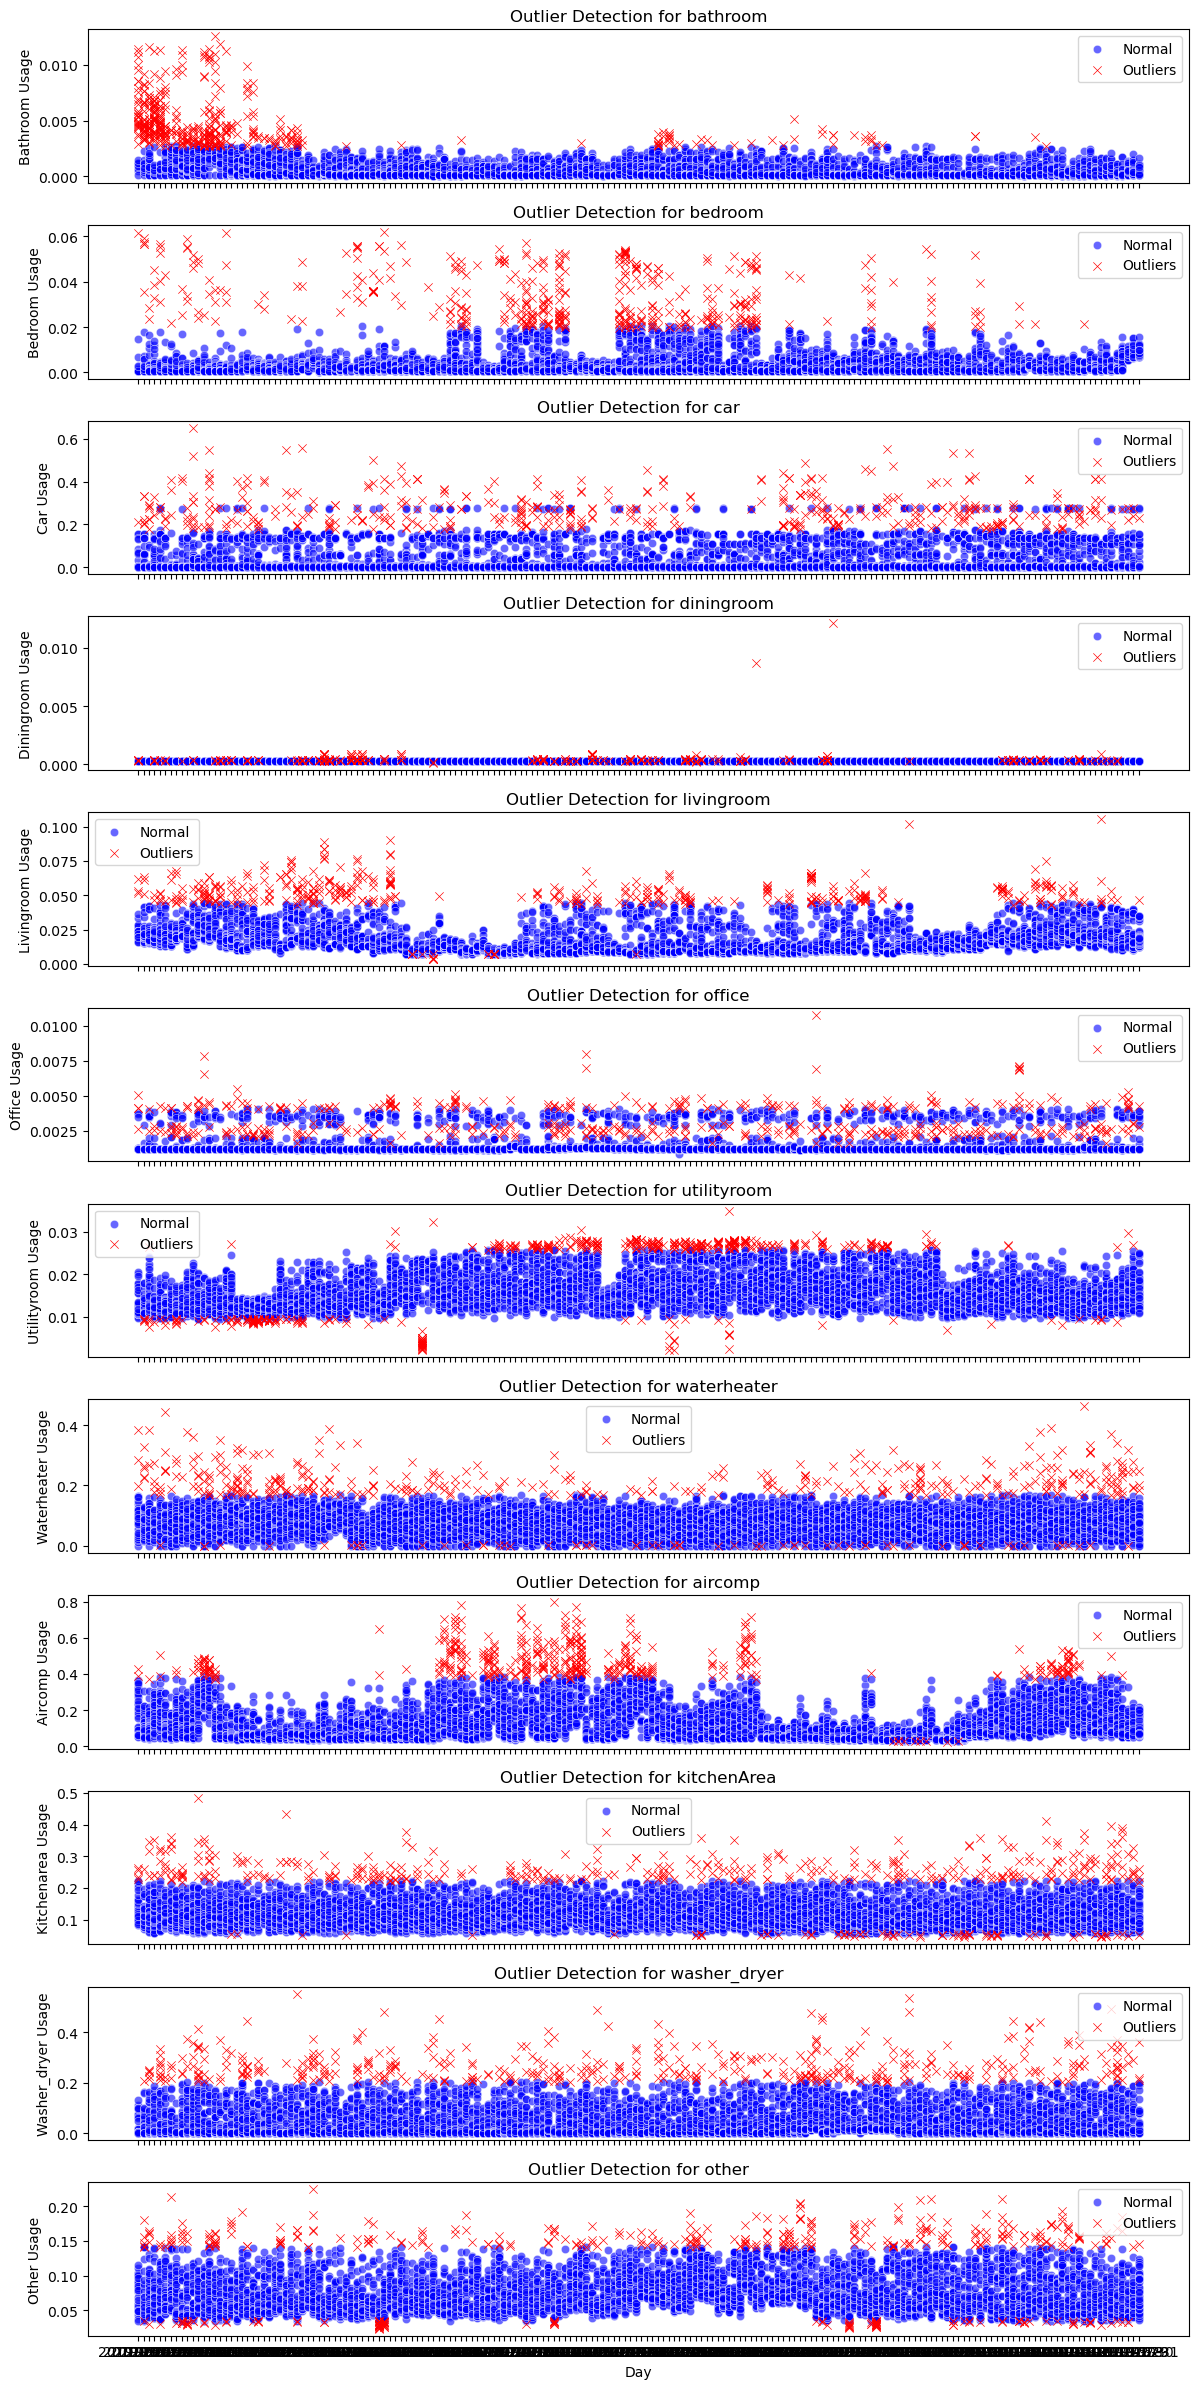

Processing outliers for city: Austin


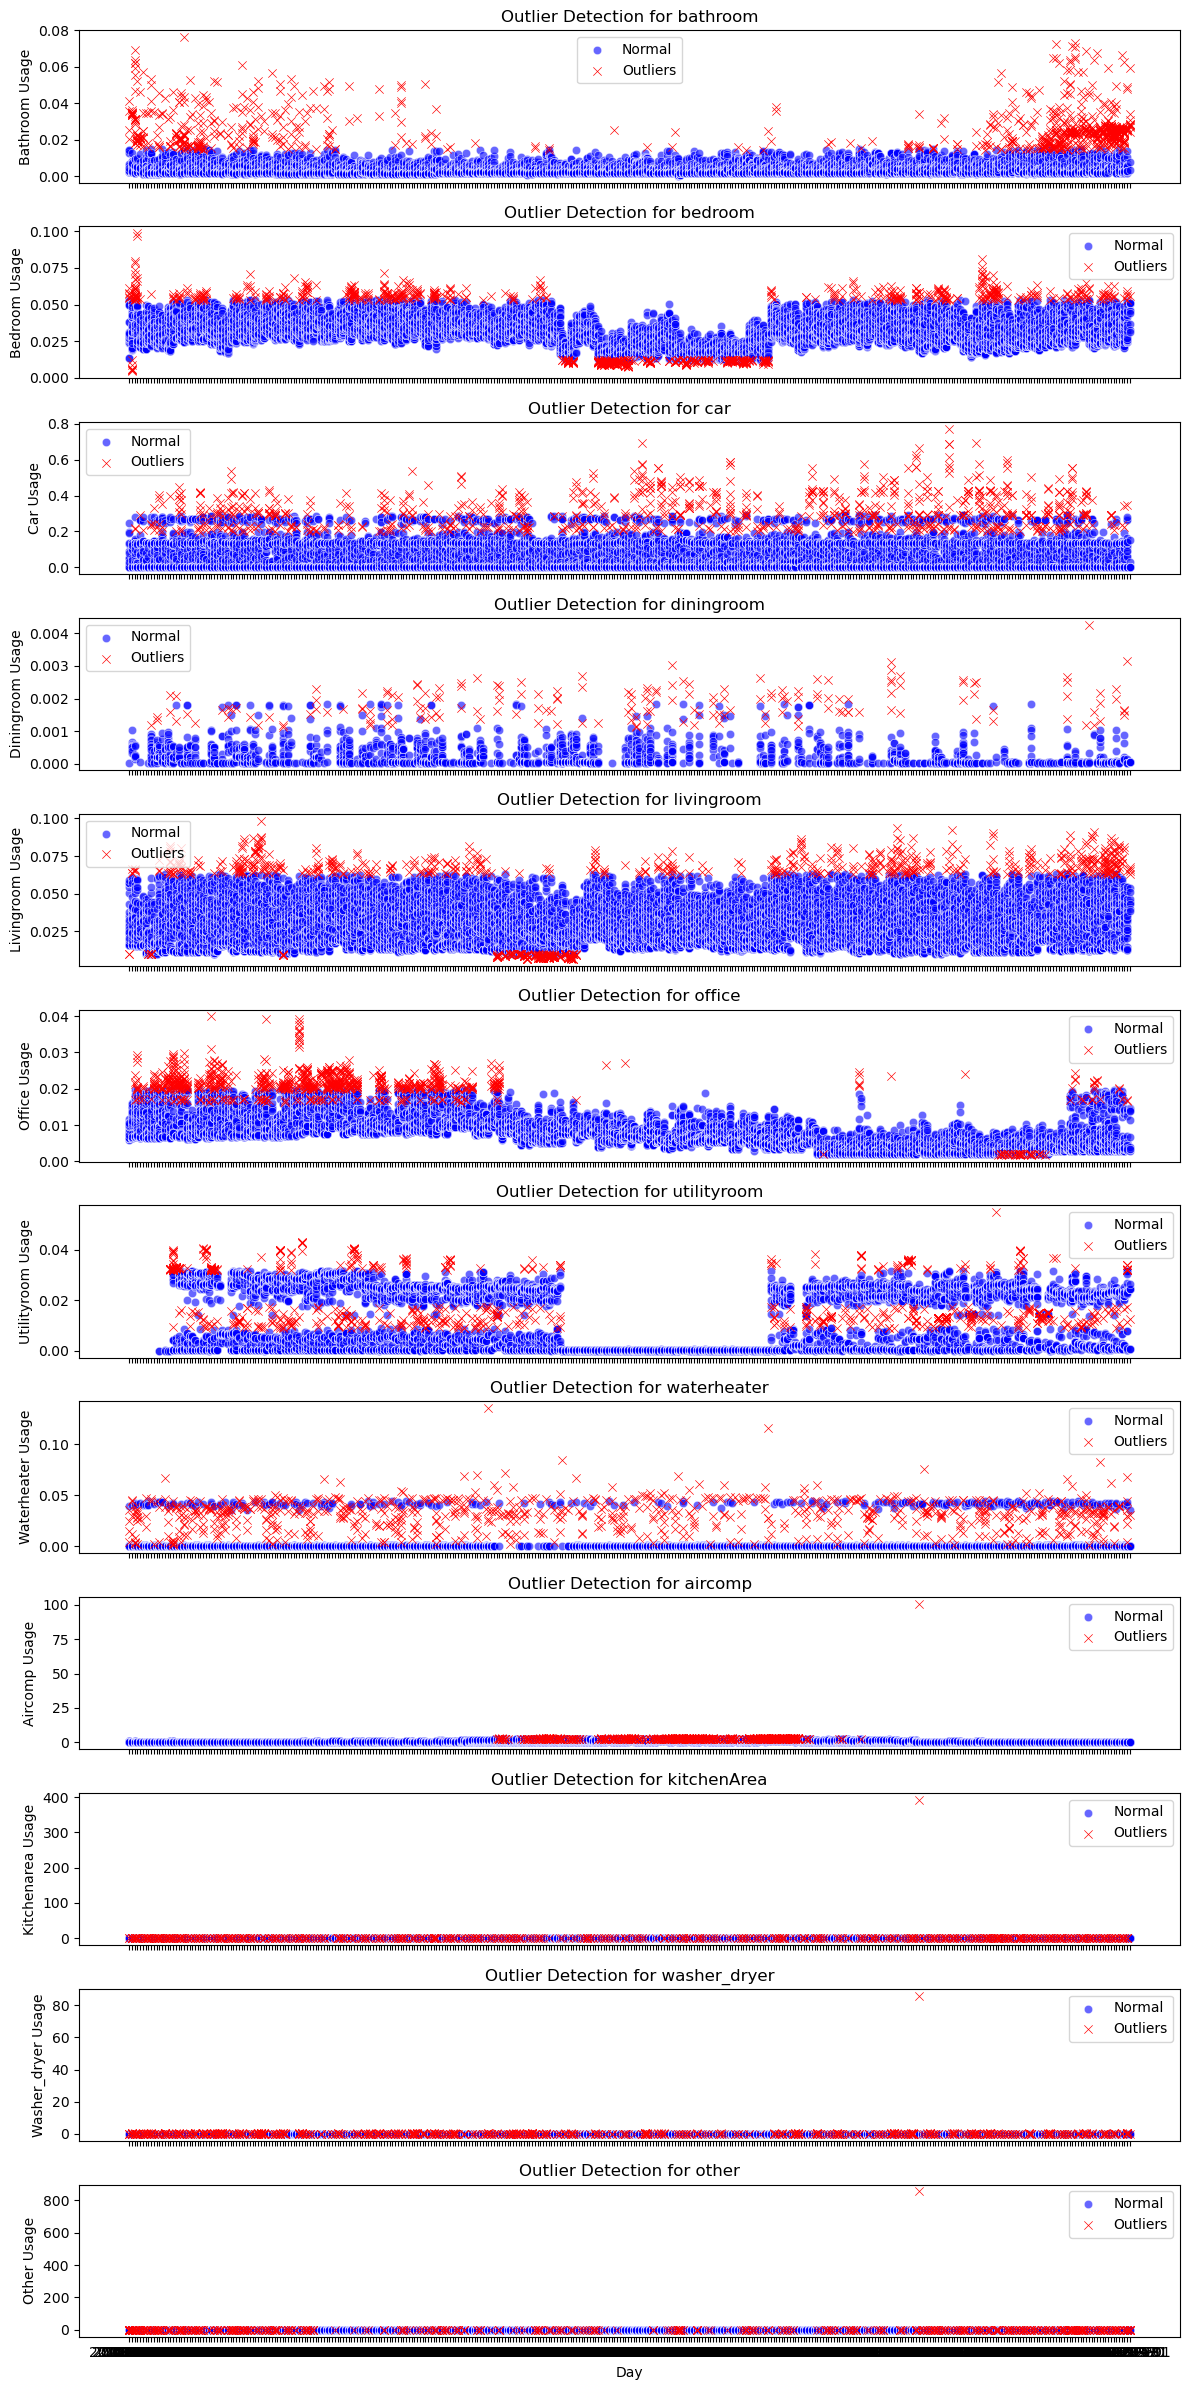

In [13]:
# Define appliance columns to analyze
appliance_cols = appliance_cols = ['bathroom', 'bedroom', 'car', 'diningroom',
       'livingroom', 'office', 'utilityroom', 'waterheater', 'aircomp',
       'kitchenArea', 'washer_dryer', 'other'
       ]

# Loop through each city, detect outliers, and visualize them
cities = df['city'].unique()
for city in cities:
    print(f"Processing outliers for city: {city}")
    
    # Filter the DataFrame for the current city
    city_df = df[df['city'] == city].copy()
    
    # Detect outliers
    city_df = detect_outliers(city_df, appliance_cols, contamination=0.05, random_state=42)
    
    # Visualize outliers
    visualize_outliers_multi(city_df, appliance_cols, x_axis='day')